# Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor

from sklearn.metrics  import mean_absolute_error

from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

# Обработка данных

In [2]:
def data_preprocess(filename = "../dataset/covid_data_train.csv"):

    df = pd.read_csv(filename, sep=',', encoding='utf-8') #Чтение файла
    df.drop('Unnamed: 0', axis=1, inplace=True)

    df.drop_duplicates(subset=["name", "district"], keep = 'first', inplace = True) #Удаление дубликатов
    df.dropna(subset = ["inf_rate"], axis = 0, inplace = True)
    
    #Удаление малозначащих признаков
    drop_columns = []
    drop_columns += list(df.loc[:,"life_quality_place_rating":"life_costs"].columns)
    drop_columns += list(['lng'])
    df.drop(drop_columns, axis=1, inplace=True)

    #Удаление колонок с именами городов и повторным названием регионв
    df.drop(["name","region_x"], axis=1, inplace=True)
    
    #Заполнение пропусков
    df.fillna(0, inplace = True)
    
    #Превращение признаков в категориальные
    df["district"] = df["district"].astype("category").cat.codes
    df["subject"] = df["subject"].astype("category").cat.codes

    return df

In [3]:
def data_split(df):

    X = df.drop("inf_rate", axis = 1)
    y = df["inf_rate"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

    return X_train, X_test, y_train, y_test

# Обучение моделей

In [4]:
# Получение датасетов для тренировки и тестирования
df = data_preprocess("../dataset/covid_data_train.csv")
X_train, X_test, y_train, y_test = data_split(df)

## Линейная регрессия

In [5]:
lin = LinearRegression()

lin.fit(X_train, y_train)

y_train_prediction = lin.predict(X_train)
y_test_prediction = lin.predict(X_test)

In [6]:
print(f'Train MAE: {mean_absolute_error(y_train, y_train_prediction)}')
print(f'Test MAE: {mean_absolute_error(y_test, y_test_prediction)}')

Train MAE: 1.9889267144199868e-11
Test MAE: 0.03935112768564392


## CatBoostRegressor

In [7]:
cat = CatBoostRegressor()

cat.fit(X_train,y_train,verbose=False)

y_train_prediction = cat.predict(X_train)
y_test_prediction = cat.predict(X_test)

In [8]:
print(f'Train MAE: {mean_absolute_error(y_train, y_train_prediction)}')
print(f'Test MAE: {mean_absolute_error(y_test, y_test_prediction)}')

Train MAE: 0.0015130812047347531
Test MAE: 0.012528054821053743


# Кросс-валидация

In [9]:
# Подготвка данных для кросс-валидации
X = df.drop("inf_rate", axis = 1)
y = df["inf_rate"]

In [10]:
# Кросс-валидация для линейной регрессии
result = cross_val_score(estimator=LinearRegression(), X=X, y=y, scoring='neg_mean_absolute_error', cv=5)
print(f'Среднее MAE равно {-result.mean()}, стандартное отклонение MAE равно {result.std()}')

Среднее MAE равно 0.0149334831630521, стандартное отклонение MAE равно 0.01874980614327597


In [11]:
# Кросс-валидация для CatBoostRegressor
result = cross_val_score(estimator=CatBoostRegressor(verbose=False), X=X, y=y, scoring='neg_mean_absolute_error', cv=5)
print(f'Среднее MAE равно {-result.mean()}, стандартное отклонение MAE равно {result.std()}')

Среднее MAE равно 0.008386732294349164, стандартное отклонение MAE равно 0.0027957192678573564


# Сохранение модели

In [12]:
cat.save_model(fname = '../model/CBR_model_v1', format = 'cbm')

# Определение значимости признаков

In [13]:
def plot_feature_importance(importance,names,model_type):
    
    #Создание массивов на основе важности признаки и их имен
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Создание DataFrame с помощью словаря
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Сортировка по уменьшению важ,ности фичей
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Отрисовка графика
    plt.figure(figsize=(20,40))
  
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

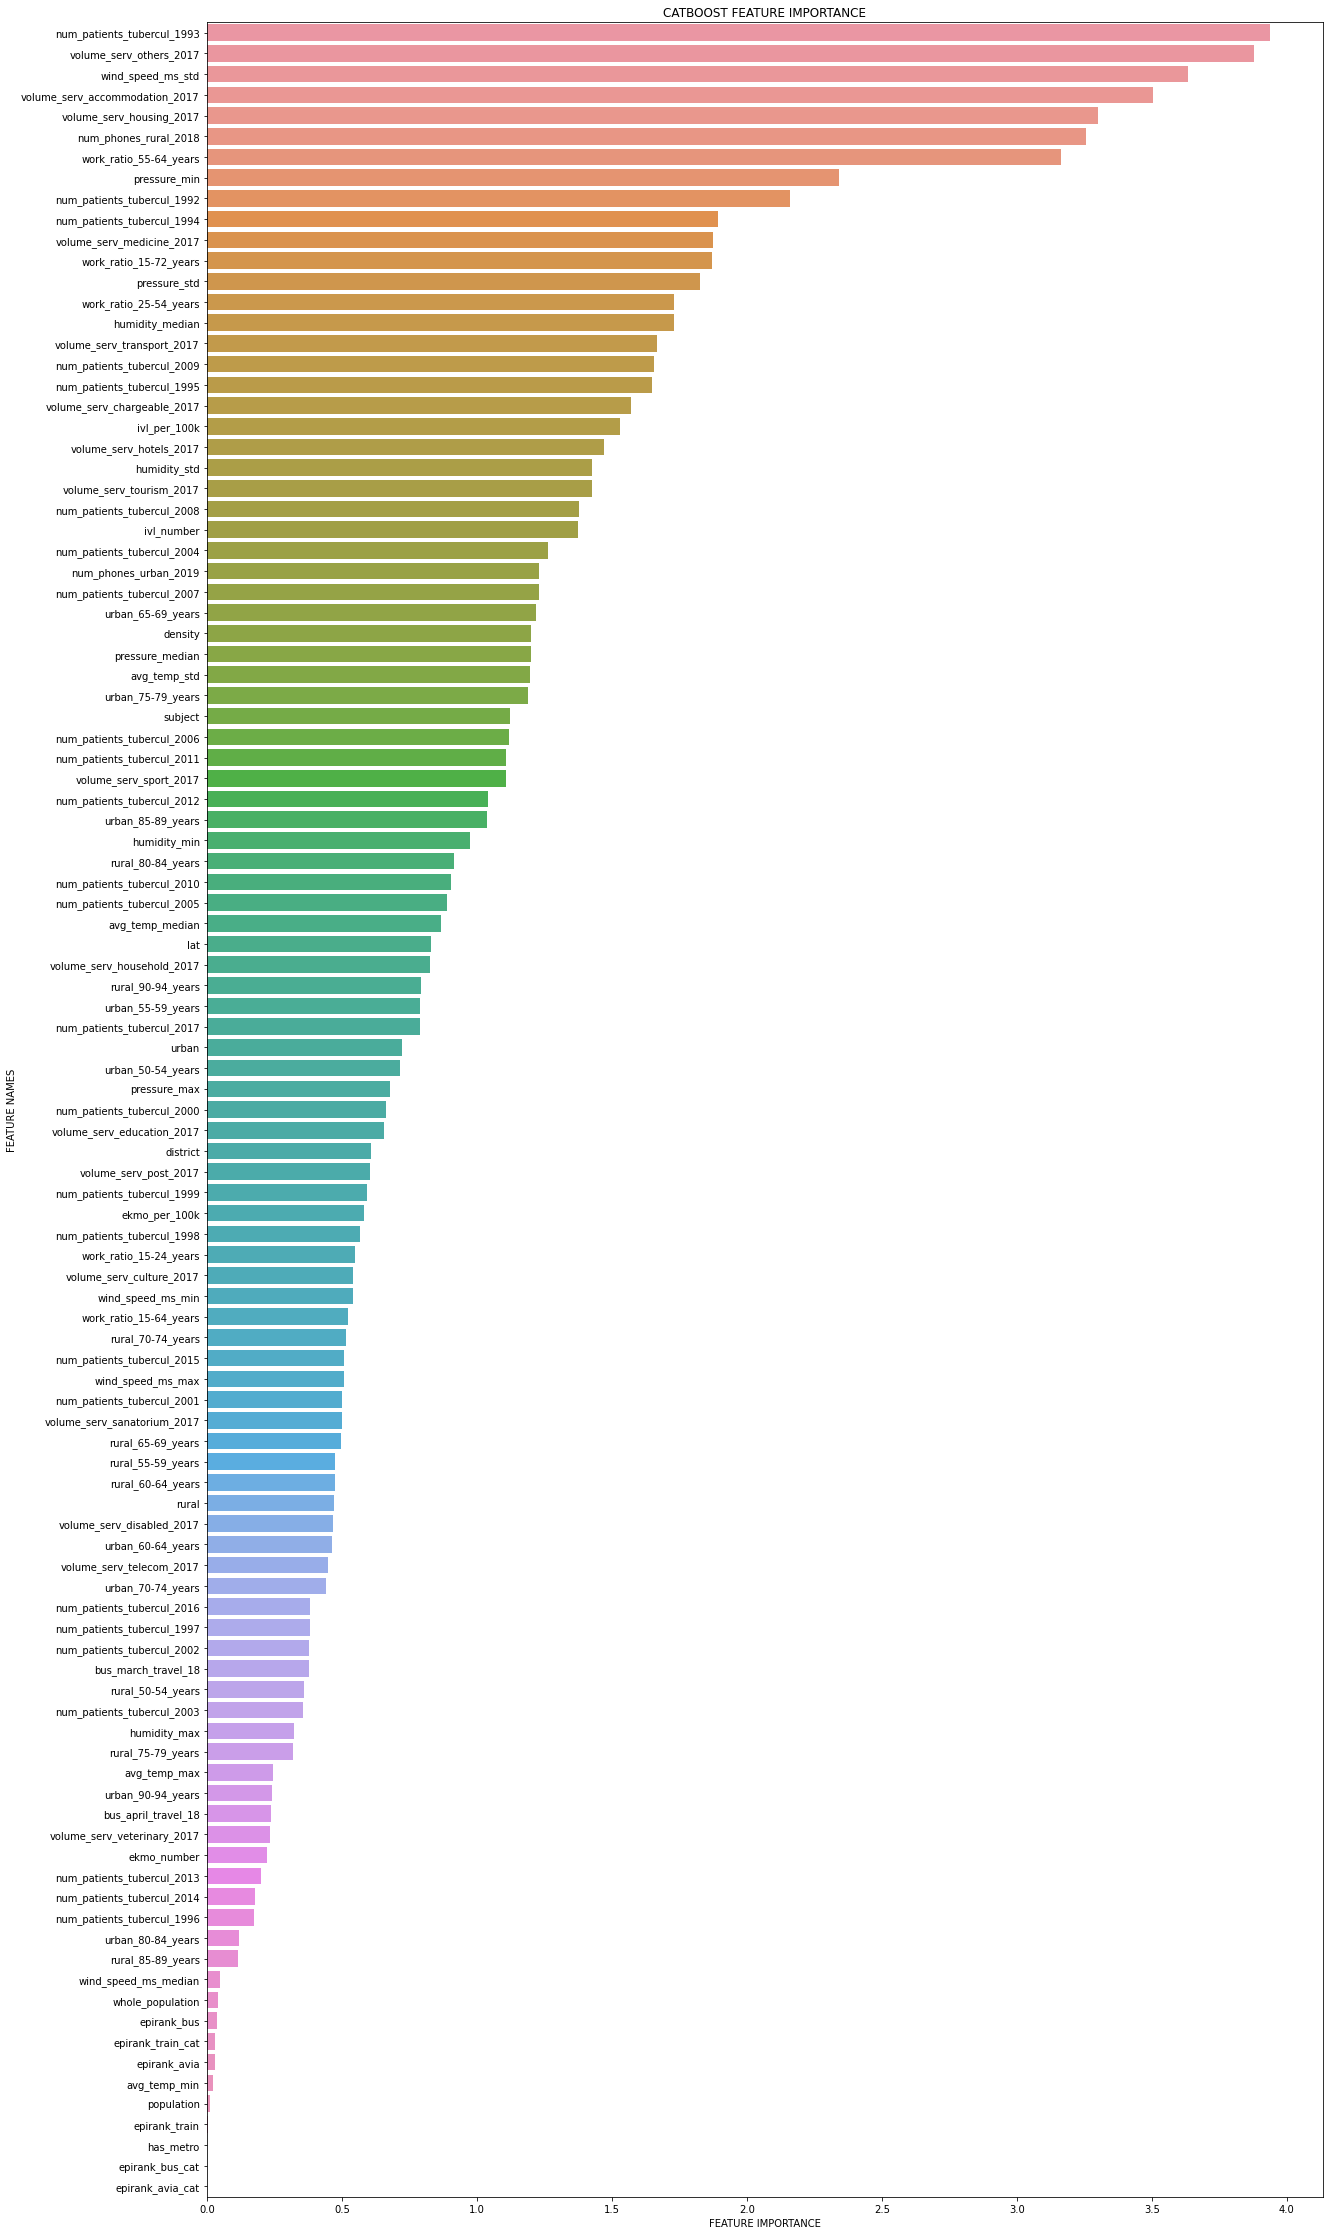

In [14]:
plot_feature_importance(cat.get_feature_importance(),X.columns,'CATBOOST')